# California Housing Prices

> The content of this notebook is based on the book **Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow 2nd**, Chapter 2.

This dataset is based on data from 1990 California census.

## Frame the Problem

A Machine Learning pipeline for real estate investments

![](https://i.imgur.com/cgtQWuB.png)

> Pipelines
> A sequence of data processing components is called a data pipeline. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply.
>
> Components typically run asynchronously. Each component pulls in a large amount of data, processes it, and spits out the result in another data store. Then, some time later, the next component in the pipeline pulls this data and spits out its own output. Each component is fairly self-contained: the interface between components is simply the data store. This makes the system simple to grasp (with the help of a data flow graph), and different teams can focus on different components. Moreover, if a component breaks down, the downstream components can often continue to run normally (at least for a while) by just using the last output from the broken component. This makes the architecture quite robust.
>
> On the other hand, a broken component can go unnoticed for some time if proper monitoring is not implemented. The data gets stale and the overall system’s performance drops.

### Select a Performance Measure

Your next step is to select a performance measure. Because this is a regression problem, the metric we choose is Root Mean Square Error (RMSE)

## Get the Data

You could use your web browser to download the file and run tar xzf `housing.tgz` to decompress it and extract the CSV file, but it is preferable to create a small function to do that. Having a function that downloads the data is useful in particular if the data changes regularly: you can write a small script that uses the function to fetch the latest data (or you can set up a scheduled job to do that automatically at regular intervals). Automating the process of fetching the data is also useful if you need to install the dataset on multiple machines.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)  
    tgz_path = os.path.join(housing_path, "housing.tgz") #used to join path
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv") 
    return pd.read_csv(csv_path)

In [ ]:
fetch_housing_data()

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Take a Quick Look at the Data Struture

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**First Overview:**

* Each value represents  one district.
* There are ten attributes.
* `total_bedrooms` has only 20.433 nonnull values, meaning that 207 districts are missing this feature.
* All attributes are numerical, except the `ocean_proximity` field.

Next let's take a look at a histogram for each numerical attribute. You can call the `hist()` method on the whole dataset, and it will plot a histogram for each numerical attribute.

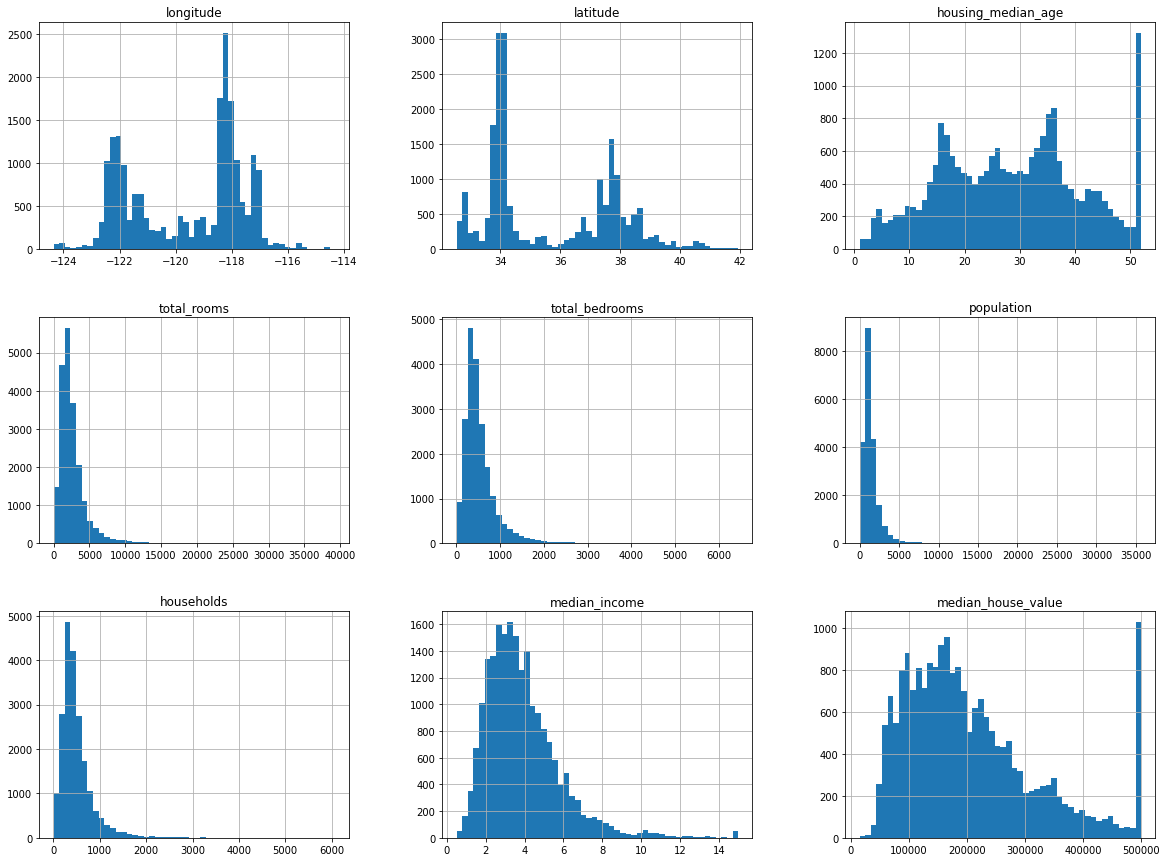

In [ ]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

**There are a few things to notice in these histograms:**

* Does the median income attribute look like it is expressed in USD? 

No, it doesn't. The income could not be that low and the the median house price is way too high for it

* In your opinion, what is the reason for those tall bins at the end for housing median age and the median house value?

  There are some districts that has a lot of middle age owners of houses that have high values??

* Are the attributes having similar scales?

  No, they're not


* Note: Many histogram are tail-heavy (skewness). This may make it harder for some ML algorithms to detect patterns. We will try transforming these attributes to have more bell-shaped distributions.

Let's take a look at the correlation

In [ ]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

### Create a Test Set

We can use `sklearn.train_test_split` to have a random sampling

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

But it's not perfect. We might run the risk of introducing a significant sampling-bias. When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is 51.3% females and 48.7% males, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called stratified sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population.

We know that median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset.

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
#Use cut when you need to segment and sort data values into bins. 
#This function is also useful for going from a continuous variable to a categorical variable

In [ ]:
housing['income_cat']

0        5
1        5
2        5
3        4
4        3
        ..
20635    2
20636    2
20637    2
20638    2
20639    2
Name: income_cat, Length: 20640, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

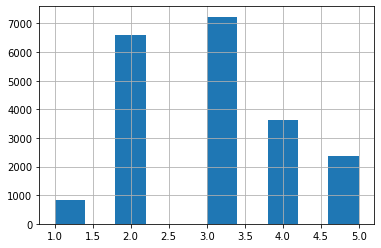

In [ ]:
housing["income_cat"].hist()


In [ ]:
housing["income_cat"].value_counts(normalize=True)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [ ]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing['income_cat'])
#stratify parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.
#here it keeps the proportion of income_cat 

In [ ]:
train_set["income_cat"].value_counts(normalize=True)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [ ]:
test_set["income_cat"].value_counts(normalize=True)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Now you should remove the income_cat attribute so the data is back to its original state:

In [ ]:
train_set = train_set.drop("income_cat", axis=1)
test_set = test_set.drop("income_cat", axis=1)

## Discover and Visualize the Data to Gain Insights

First, make sure you have put the test set aside and you are only exploring the training set. Let's create a copy so that you can play with the training set without harming it:

In [ ]:
housing = train_set.copy()

### Visualize Geographical Data

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure bad_visualization_plot


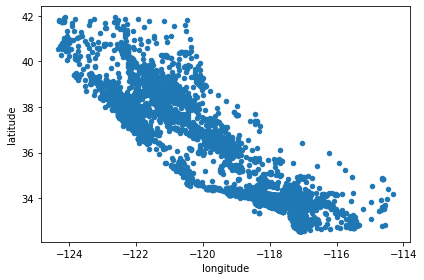

In [ ]:
housing.plot(kind='scatter', x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


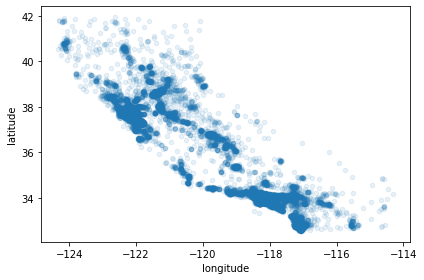

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Saving figure housing_prices_scatterplot


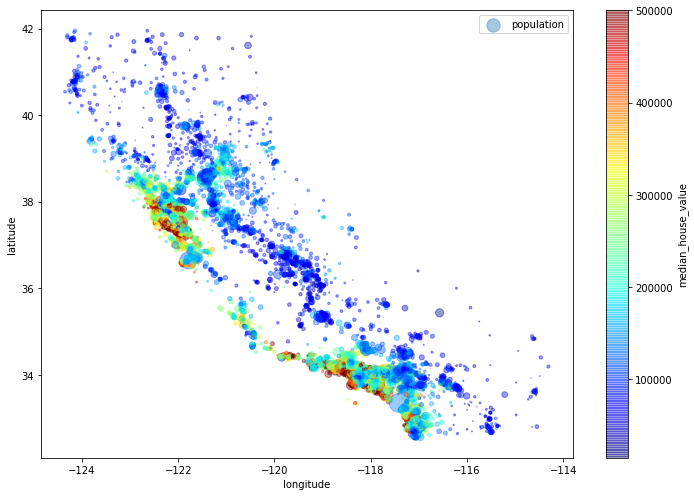

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [ ]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/california.png', <http.client.HTTPMessage at 0x7f9b2ea43f50>)

Saving figure california_housing_prices_plot


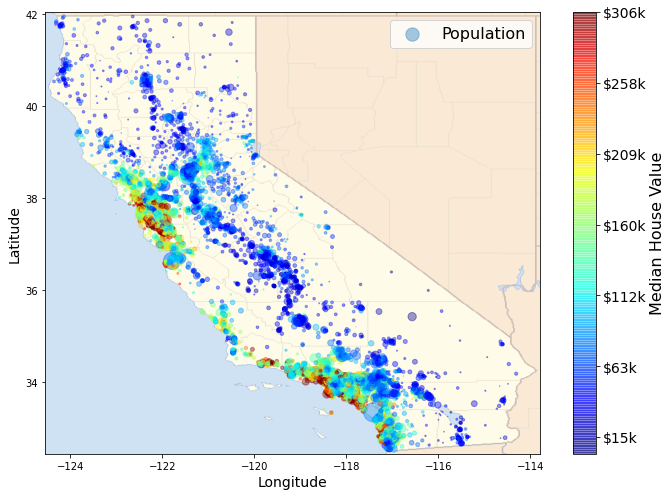

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### Looking for Correlations

> **WARNING:** The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to 0, then y generally goes up”). 

In [ ]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

Another way to check for correlation between attributes is to use the pandas scatter_matrix() function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 112 = 121 plots, which would not fit on a page—so let’s just focus on a few promising attributes that seem most correlated with the median housing value

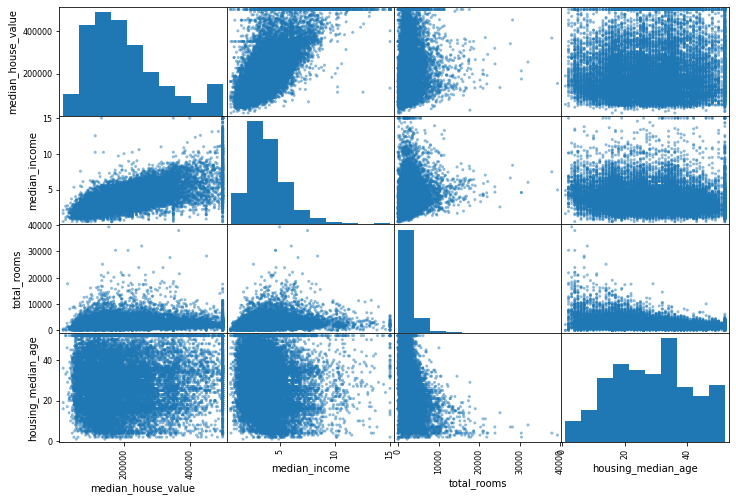

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

# seaborn also has a similiar function for this plot
# sns.pairplot(housing[attributes])

plt.show()

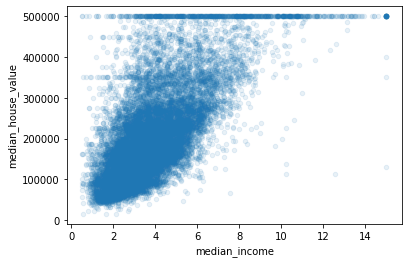

In [ ]:
# The most promising attribute to predict the median house value is the median income

housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

**This plot reveals a few things:**
* The correlation is indeed very strong.
* The price cap is clearly visible as a horizontal line at `$500,000`
* But this plot reveals other less obvious straight lines: a horizontal line around `$450,000`, another around `$350,000`

### Experimenting with Attribute Combinations

There are a few things we could try manipulating the data before training ML algorithms. Example, the number of rooms in a district is not very useful. What we really want is the number of rooms per household. Similiar with the total number of bedrooms, we probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at.

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690647
rooms_per_household         0.158485
total_rooms                 0.133989
housing_median_age          0.103706
households                  0.063714
total_bedrooms              0.047980
population_per_household   -0.022030
population                 -0.026032
longitude                  -0.046349
latitude                   -0.142983
bedrooms_per_room          -0.257419
Name: median_house_value, dtype: float64

Not bad! The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

> This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype. But this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

## Prepare the Data for ML algorithms

It’s time to prepare the data for your Machine Learning algorithms. Instead of doing this manually, you should write functions for this purpose.

In [ ]:
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

### Data Cleaning

We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this. We have 3 options:

```python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

Here we choose option 3, we should compute the median value on the training set and use it to fill the missing values in the training set. 

> Don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

Scikit-Learn provides a handy class to take care of missing values: `SimpleImputer`. Here is how to use it. First, you need to create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# the median can only be computed on numerical attributes
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

print(imputer.statistics_)
print(housing_num.median().values)

[-118.51     34.26     29.     2129.      437.     1167.      410.
    3.5458]
[-118.51     34.26     29.     2129.      437.     1167.      410.
    3.5458]


Now you can use this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [ ]:
X = imputer.transform(housing_num)

# The result is a plain NumPy array containing the transformed features. 
# If you want to put it back into a pandas DataFrame:
pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542
...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192


### Handling Categorical Attributes


In [ ]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     7341
INLAND        5227
NEAR OCEAN    2086
NEAR BAY      1854
ISLAND           4
Name: ocean_proximity, dtype: int64

https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

housing_cat = housing[["ocean_proximity"]]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

print(housing_cat[:10])
print(housing_cat_encoded[:10])
print(f"Encoder's categories {ordinal_encoder.categories_}")

      ocean_proximity
14196      NEAR OCEAN
8267       NEAR OCEAN
17445      NEAR OCEAN
14265      NEAR OCEAN
2271           INLAND
17848       <1H OCEAN
6252        <1H OCEAN
9389         NEAR BAY
6113        <1H OCEAN
6061        <1H OCEAN
[[4.]
 [4.]
 [4.]
 [4.]
 [1.]
 [0.]
 [0.]
 [3.]
 [0.]
 [0.]]
Encoder's categories [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

> Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. You can use it mostly like a normal 2D array,21 but if you really want to convert it to a (dense) NumPy array, just call the toarray() method:

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### Custom Transformer

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes.


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                      bedrooms_per_room]


attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
housing_extra_attribs.shape

(16512, 12)

In [ ]:
housing.shape

(16512, 9)

### Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales.

There are two common ways to get all attributes to have the same scale: `min-max scaling`(normalization) and `standardization`.

* Min-Max-Scaling: values are shifted so that they end up ranging from 0 to 1. Scikit-learn provides a transformer called `MinMaxScaler` for this.
* Standardization: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Standardization does not bound values to a specific range, and is much less affected by outliers. Scikit-learn provides a transformer called `StandardScaler` for this.

### Transformation Pipeline

As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column.

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

> **Tip:** Instead of using a transformer, you can specify the string "drop" if you want the columns to be dropped, or you can specify "passthrough" if you want the columns to be left untouched. By default, the remaining columns (i.e., the ones that were not listed) will be dropped, but you can set the remainder hyperparameter to any transformer (or to "passthrough") if you want these columns to be handled differently.

## Select and Train a Model

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67593.20745775253

This is better than nothing, but clearly not a great score: most districts’ median_housing_values range between `$120,000` and `$265,000`, so a typical prediction error of `$68,628` is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.

Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Your code here
# Fit a DecisionTreeRegressor to your training set (housing_prepared) and training label (housing_labels)
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
# Make a prediction on housing_prepared and calculate RMSE b/t your prediction and housing_labels
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data.

### Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the train_test_split() function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It’s a bit of work, but nothing too difficult, and it would work fairly well.

A great alternative is to use Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [ ]:
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor()

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores) # we have to use this negative trick as cross_val_score don't really have a normal mean_squared_error 

In [ ]:
tree_rmse_scores

array([66141.10408846, 70346.3655342 , 68978.96604615, 71327.02133853,
       74232.3954248 , 65955.20160088, 67262.12589778, 67515.1338777 ,
       66078.0879564 , 69692.51938556])

> Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes -scores before calculating the square root.

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
display_scores(tree_rmse_scores)

Scores: [66141.10408846 70346.3655342  68978.96604615 71327.02133853
 74232.3954248  65955.20160088 67262.12589778 67515.1338777
 66078.0879564  69692.51938556]
Mean: 68752.89211504572
Standard deviation: 2562.8456783977877


Let’s try one last model now: the RandomForestRegressor.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Your code here
# Fit a random forest regressor on training data (housing_prepared) and training label (housing_labels), 
# and then make a prediction on housing_labels and calculate the RMSE
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18606.771970406797

In [ ]:
# Now we try cross_val_score on RandomForestRegressor, with 10 folds
# Your code here
forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [ ]:
def timeConversion(s):
    time = s[-2:]
    if time == "AM" and s[:2] == "12":
        s = "00" + s[2:]
    elif time == "PM" and s[:2] != "12":
      s = str(int(s[:2]) + 12) + s[2:]
    return s

In [ ]:
timeConversion("00:05:45AM")

'00:05:45AM'

In [ ]:
display_scores(forest_rmse_scores)

Scores: [47388.10119218 51669.90179458 49650.47984504 52152.41755471
 52793.03724823 47197.35375976 47448.99433518 51001.92003144
 49687.87772743 50442.32765645]
Mean: 49943.24111450161
Standard deviation: 1944.0645071990382


Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data. 

You should save every model you experiment with so that you can come back easily to any model you want. Make sure you save both the hyperparameters and the trained parameters, as well as the cross-validation scores and perhaps the actual predictions as well. This will allow you to easily compare scores across model types, and compare the types of errors they make. You can easily save Scikit-Learn models by using Python’s pickle module or by using the joblib library, which is more efficient at serializing large NumPy arrays (you can install this library using pip):

In [ ]:
import joblib

joblib.dump(forest_reg, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")

## Fine-Tune your Model

Let’s assume that you now have a shortlist of promising models. You now need to fine-tune them. Let’s look at a few ways you can do that.

### Grid Search

One option would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

Instead, you should get Scikit-Learn’s GridSearchCV to search for you. All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values. 

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # {'n_estimators': [3, 10], 'max_features': [2, 3, 4]}, 
  ]

forest_reg = RandomForestRegressor(bootstrap=False)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
RandomForestRegressor(**grid_search.best_params_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

62692.36311106451 {'max_features': 2, 'n_estimators': 3}
53745.71771171261 {'max_features': 2, 'n_estimators': 10}
51472.677133971294 {'max_features': 2, 'n_estimators': 30}
59554.340429819946 {'max_features': 4, 'n_estimators': 3}
51610.155038456105 {'max_features': 4, 'n_estimators': 10}
49355.38949858146 {'max_features': 4, 'n_estimators': 30}
57156.30078125932 {'max_features': 6, 'n_estimators': 3}
51346.91818290056 {'max_features': 6, 'n_estimators': 10}
48750.368770027475 {'max_features': 6, 'n_estimators': 30}
57533.8004703214 {'max_features': 8, 'n_estimators': 3}
51561.53534972729 {'max_features': 8, 'n_estimators': 10}
49525.94787310887 {'max_features': 8, 'n_estimators': 30}


### Randomized Search

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use `RandomizedSearchCV` instead. This class can be used in much the same way as the `GridSearchCV` class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:

If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).

Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

62692.36311106451 {'max_features': 2, 'n_estimators': 3}
53745.71771171261 {'max_features': 2, 'n_estimators': 10}
51472.677133971294 {'max_features': 2, 'n_estimators': 30}
59554.340429819946 {'max_features': 4, 'n_estimators': 3}
51610.155038456105 {'max_features': 4, 'n_estimators': 10}
49355.38949858146 {'max_features': 4, 'n_estimators': 30}
57156.30078125932 {'max_features': 6, 'n_estimators': 3}
51346.91818290056 {'max_features': 6, 'n_estimators': 10}
48750.368770027475 {'max_features': 6, 'n_estimators': 30}
57533.8004703214 {'max_features': 8, 'n_estimators': 3}
51561.53534972729 {'max_features': 8, 'n_estimators': 10}
49525.94787310887 {'max_features': 8, 'n_estimators': 30}


In [ ]:
best_randomforest = rnd_search.best_estimator_

### Analyze the best models and their errors

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

**Note**: research feature_importances
for linear regression, the condition is that all of the columns must not have any correlation to each other (x1, x2,...)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
#every model will have the attribute feature_importances_
feature_importances

array([7.98428932e-02, 7.38456879e-02, 4.02213607e-02, 1.62518137e-02,
       1.53864602e-02, 1.64148415e-02, 1.51026006e-02, 3.18335603e-01,
       7.80212993e-02, 1.09603604e-01, 6.30074736e-02, 7.88757922e-03,
       1.57958473e-01, 1.79860908e-04, 2.75230549e-03, 5.18814455e-03])

Let’s display these importance scores next to their corresponding attribute names:

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3183356026810094, 'median_income'),
 (0.15795847274024213, 'INLAND'),
 (0.1096036037383413, 'pop_per_hhold'),
 (0.07984289319948454, 'longitude'),
 (0.07802129925698256, 'rooms_per_hhold'),
 (0.07384568789057237, 'latitude'),
 (0.06300747363076085, 'bedrooms_per_room'),
 (0.04022136066721758, 'housing_median_age'),
 (0.016414841537032408, 'population'),
 (0.01625181366760312, 'total_rooms'),
 (0.015386460231603068, 'total_bedrooms'),
 (0.015102600582841495, 'households'),
 (0.007887579221959849, '<1H OCEAN'),
 (0.005188144552771187, 'NEAR OCEAN'),
 (0.002752305493590268, 'NEAR BAY'),
 (0.00017986090798800317, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others).

You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.).

### Evaluate Your System on the Test Set

Now is the time to evaluate the final model on the test set.

In [ ]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)   

final_rmse

48831.26274492937

We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46603.59950729, 50961.64200154])

## Launch, Monitor, and Maintain Your System



<br/>

![](https://i.imgur.com/XElFQeQ.png)

<br/>

You now need to get your solution ready for production

* One way to do this is to save the trained Scikit-Learn model (e.g., using joblib), including the full preprocessing and prediction pipeline, then load this trained model within your production environment and use it to make predictions by calling its predict() method.
* Alternatively, you can wrap the model within a dedicated web service that your web application can query through a REST API (see figure above). 
* Another popular strategy is to deploy your model on the cloud, for example on Google Cloud AI Platform (formerly known as Google Cloud ML Engine): just save your model using joblib and upload it to Google Cloud Storage (GCS), then head over to Google Cloud AI Platform and create a new model version, pointing it to the GCS file.

But deployment is not the end of the story. You also need to write monitoring code to check your system’s live performance at regular intervals and trigger alerts when it drops. 

If the data keeps evolving, you will need to update your datasets and retrain your model regularly. You should probably automate the whole process as much as possible. Here are a few things you can automate:

* Collect fresh data regularly and label it (e.g., using human raters).

* Write a script to train the model and fine-tune the hyperparameters automatically. This script could run automatically, for example every day or every week, depending on your needs.

* Write another script that will evaluate both the new model and the previous model on the updated test set, and deploy the model to production if the performance has not decreased (if it did, make sure you investigate why).

You should also make sure you evaluate the model’s input data quality. Sometimes performance will degrade slightly because of a poor-quality signal. For example, you could trigger an alert if more and more inputs are missing a feature, or if its mean or standard deviation drifts too far from the training set, or a categorical feature starts containing new categories.

Finally, make sure you keep backups of every model you create and have the process and tools in place to roll back to a previous model quickly, in case the new model starts failing badly for some reason. 

As you can see, Machine Learning involves quite a lot of infrastructure, so don’t be surprised if your first ML project takes a lot of effort and time to build and deploy to production. Fortunately, once all the infrastructure is in place, going from idea to production will be much faster.



**Congratulations! You already know quite a lot about Machine Learning.**

# Now, let's start with the real lab today!

**Question 1**: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [ ]:
# Remember what we got feature importances already
feature_importances

array([7.98428932e-02, 7.38456879e-02, 4.02213607e-02, 1.62518137e-02,
       1.53864602e-02, 1.64148415e-02, 1.51026006e-02, 3.18335603e-01,
       7.80212993e-02, 1.09603604e-01, 6.30074736e-02, 7.88757922e-03,
       1.57958473e-01, 1.79860908e-04, 2.75230549e-03, 5.18814455e-03])


 (-arr).argsort() to get an array of all the indices of arr sorted in descending order by the corresponding elements of arr. Slice the resulting array using [:N] to find the N maximum indices.

In [ ]:
# Define a function to select the indices of the top k feature importances
def indices_of_top_k(arr, k):
    return (-arr).argsort()[:k]
    #np.sort(np.argpartition(arr, -k)[-k:])

Let's define the number of top features we want to keep:

In [ ]:
k = 5

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 7, 12,  9,  0,  8])

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 7, 12,  9,  0,  8])

Now let's look for the indices of the top k features:

In [ ]:
np.array(attributes)[top_k_feature_indices]

array(['median_income', 'INLAND', 'pop_per_hhold', 'longitude',
       'rooms_per_hhold'], dtype='<U18')

In [ ]:
np.array(attributes)[top_k_feature_indices]

array(['median_income', 'INLAND', 'pop_per_hhold', 'longitude',
       'rooms_per_hhold'], dtype='<U18')

Now let's define our TopFeatureSelector class




Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
#get the top features from the features importance from the gridsearch?
# Define a function to select the indices of the top k feature importances
def indices_of_top_k(arr, k):
    return (-arr).argsort()[:k]
    #np.sort(np.argpartition(arr, -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        # Your code here
        return self
    def transform(self, X):
        # Your code here
        self.top_indices = indices_of_top_k(self.feature_importances, self.k)
        
        return X[:, self.top_indices]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [ ]:
# The pipeline should have the full pipeline and the top feature selectors you wrote above
#
preparation_and_feature_selection_pipeline = Pipeline(steps = [(['prepared', full_pipeline]), (['top_feature', TopFeatureSelector(feature_importances, k)])])


In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Now let's look for the indices of the top k features:

In [ ]:
housing_prepared_top_k_features[0:3]
#returns first 3 rows of 5 columns with the most important features

array([[-0.326196  ,  0.        ,  0.05137609,  1.27258656, -0.17491646],
       [-0.03584338,  0.        , -0.11736222,  0.70916212, -0.40283542],
       [ 0.14470145,  0.        , -0.03227969, -0.44760309,  0.08821601]])

Now let's double check that these are indeed the top k features:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

array([[-0.326196  ,  0.        ,  0.05137609,  1.27258656, -0.17491646],
       [-0.03584338,  0.        , -0.11736222,  0.70916212, -0.40283542],
       [ 0.14470145,  0.        , -0.03227969, -0.44760309,  0.08821601]])

If they are the same then it is good news!

**Question 2**: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [ ]:
# other models: xgboost, lightgbm,...
# They're not in sklearn so cannot put them in pipeline

In [ ]:
# The pipeline should have 
# 1. full_pipeline
# 2. TopFeatureSelector
# 3. A ML model, for example RandomForestRegressor
prepare_select_and_predict_pipeline = Pipeline(steps = [(['prepared', full_pipeline]), 
                                                        (['top_feature', TopFeatureSelector(feature_importances, k)]), (['model', RandomForestRegressor(randomstate=42)])])


In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('prepared',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                 

Let's try the full pipeline on a few instances:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions: ", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels: ", list(some_labels))

Predictions:  [107266.66666667 308900.         160533.33333333  93400.        ]
Labels:  [103000.0, 382100.0, 172600.0, 93400.0]


Well, the full pipeline seems to work fine if it can print out 5 predictions for 5 labels

**Question 3**: So far, we can do gridsearch with a ML model but can we do GridSearch for the whole pipeline, can you make GridSearchCV works with the prepare_select_and_predict_pipeline pipeline ? 

In [ ]:
# To get a list of all the names for each of element in your big pipeline, use .get_params(). For example:
for i in prepare_select_and_predict_pipeline.get_params():#.keys()
    print(i)

memory
steps
verbose
prepared
top_feature
model
prepared__n_jobs
prepared__remainder
prepared__sparse_threshold
prepared__transformer_weights
prepared__transformers
prepared__verbose
prepared__num
prepared__cat
prepared__num__memory
prepared__num__steps
prepared__num__verbose
prepared__num__imputer
prepared__num__attribs_adder
prepared__num__std_scaler
prepared__num__imputer__add_indicator
prepared__num__imputer__copy
prepared__num__imputer__fill_value
prepared__num__imputer__missing_values
prepared__num__imputer__strategy
prepared__num__imputer__verbose
prepared__num__std_scaler__copy
prepared__num__std_scaler__with_mean
prepared__num__std_scaler__with_std
prepared__cat__categories
prepared__cat__drop
prepared__cat__dtype
prepared__cat__handle_unknown
prepared__cat__sparse
top_feature__feature_importances
top_feature__k
model__bootstrap
model__ccp_alpha
model__criterion
model__max_depth
model__max_features
model__max_leaf_nodes
model__max_samples
model__min_impurity_decrease
model__mi

In [ ]:
#have chage a few things so run again next time
# the imputer strategy is 'mean', 'median', 'most_frequent' 
# select the best k features: from 1 to the number of features
param_grid = [{'prepared__num__imputer__strategy ': ['mean', 'median', 'most_frequent'], 
               'top_feature__k': list(range(1, len(feature_importances)+1)), 'model__max_leaf_nodes':list(range(1,10))}]
# GridSearchCV: let have cv =5, verbose =2 so we can see more information, scoring = 'neg_mean_squared_error'
grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose=1, n_jobs=-1, return_train_score=True)
grid_search_prep.fit(housing, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('prepared',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                        

In [ ]:
grid_search_prep.best_params_

{'prepared__num__imputer__strategy': 'mean', 'top_feature__k': 8}

In [ ]:
np.sqrt(-grid_search_prep.best_score_)

49884.14084259488

In [ ]:
predictions = grid_search_prep.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, predictions)
sqrt_score = np.sqrt(mse)
sqrt_score

49587.28115263359